In [2]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [3]:
tweets = pd.read_excel('11Apr_to_30Apr_Data.xlsx')
tweets.head()

,Unnamed: 0,created_at,id_str,user_name,user_id,in_reply_to_status_id_str,in_reply_to_username,like_count,full_text
0,0,2022-04-11 23:59:55+00:00,1513668195273600000,Chance178,139130531,NaN,NaN,1,Inside Johnny Depp and Amber Heard's legal bat...
1,1,2022-04-11 23:59:40+00:00,1513668133936049920,Big_City_Radio,943105000000000000,NaN,NaN,0,Inside Johnny Depp and Amber Heard's legal bat...
2,2,2022-04-11 23:59:38+00:00,1513668125975200000,BerkleyBearNews,787546010,NaN,NaN,0,Inside Johnny Depp and Amber Heard's legal bat...
3,3,2022-04-11 23:59:08+00:00,1513668001127660032,xalfeed,9355842,NaN,NaN,0,BBC News - US &amp; Canada: Inside Johnny Depp...
4,4,2022-04-11 23:57:41+00:00,1513667635816320000,SNSDEIDADES,2742889411,NaN,NaN,5,Los fans de Amber heard be like #JusticeForJoh...


In [4]:
df = tweets.filter(['full_text', "created_at"], axis=1)
# df1 = df[df["Language"] == "en"]
df_jan = df[(df['created_at'] > '2022-04-11') & (df['created_at'] < '2022-04-18')]
df2 = df_jan.dropna()
df2

,full_text,created_at
0,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:55+00:00
1,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:40+00:00
2,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:38+00:00
3,BBC News - US &amp; Canada: Inside Johnny Depp...,2022-04-11 23:59:08+00:00
4,Los fans de Amber heard be like #JusticeForJoh...,2022-04-11 23:57:41+00:00
...,...,...
23480,This johnny depp and Amber Heard trail isn’t b...,2022-04-17 00:01:20+00:00
23481,It’s really disappointing they took Johnny dep...,2022-04-17 00:01:10+00:00
23482,So she got kicked out of court recently. Is pa...,2022-04-17 00:01:03+00:00
23483,AMBER HEARD AS JUDE LIPPMAN IN ONE MORE TIME (...,2022-04-17 00:00:00+00:00


# Data cleaning

In [5]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [6]:
df2.head()

,full_text,created_at,clean_text
0,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:55+00:00,"[inside, legal, battle]"
1,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:40+00:00,"[inside, legal, battle]"
2,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:38+00:00,"[inside, legal, battle]"
3,BBC News - US &amp; Canada: Inside Johnny Depp...,2022-04-11 23:59:08+00:00,"[bbc, news, us, canada, inside, legal, battle]"
4,Los fans de Amber heard be like #JusticeForJoh...,2022-04-11 23:57:41+00:00,"[los, fans, de, like]"


In [7]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,created_at,clean_text
0,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:55+00:00,[battle]
1,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:40+00:00,[battle]
2,Inside Johnny Depp and Amber Heard's legal bat...,2022-04-11 23:59:38+00:00,[battle]
3,BBC News - US &amp; Canada: Inside Johnny Depp...,2022-04-11 23:59:08+00:00,[battle]
4,Los fans de Amber heard be like #JusticeForJoh...,2022-04-11 23:57:41+00:00,[]


In [8]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


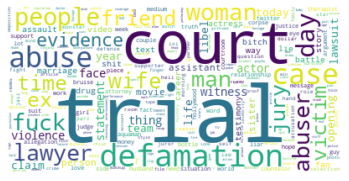

In [9]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

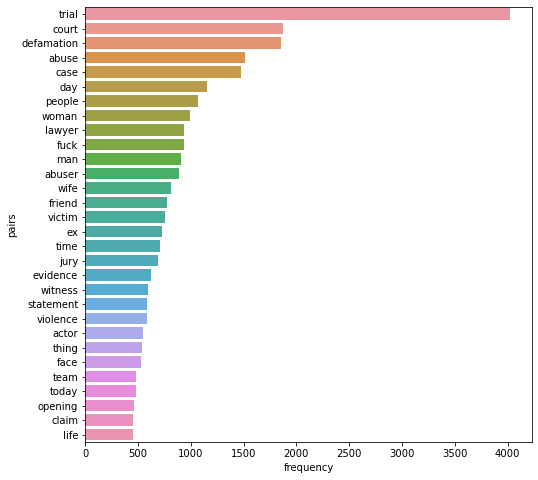

In [10]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [11]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['battle'], ['battle'], ['battle']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'battle'), (1, 'question'), (2, 'trial'), (3, 'celebrity'), (4, 'tea'), (5, 'week'), (6, 'witness'), (7, 'defamation'), (8, 'ex'), (9, 'mail'), (10, 'online'), (11, 'see'), (12, 'story'), (13, 'today'), (14, 'wife'), (15, 'actor'), (16, 'libel'), (17, 'jury'), (18, 'suit'), (19, 'bed'), (20, 'fuck'), (21, 'shit'), (22, 'fan'), (23, 'number'), (24, 'work'), (25, 'villain'), (26, 'supporter'), (27, 'talk'), (28, 'abuser'), (29, 'lol'), (30, 'movie'), (31, 'case'), (32, 'earth'), (33, 'lie'), (34, 'time'), (35, 'link'), (36, 'actress'), (37, 'lawsuit'), (38, 'selection'), (39, 'entertainment'), (40, 'friend'), (41, 'industry'), (42, 'woman'), (43, 'cover'), (44, 'director'), (45, 'ff'), (46, 'fight'), (47, 'hour'), (48, 'installment'), (49, 'irl')]

Total Vocabulary Size: 3281


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [14]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [15]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3794836153062527
Perplexity Score:  -6.441659795883458

topic number:  3
Coherence Score:  0.3472907138003157
Perplexity Score:  -6.514127304317038

topic number:  4
Coherence Score:  0.3526283493123657
Perplexity Score:  -6.57645894631614

topic number:  5
Coherence Score:  0.3521463974898258
Perplexity Score:  -6.590162397254638

topic number:  6
Coherence Score:  0.38974697402928093
Perplexity Score:  -6.635203226960713

topic number:  7
Coherence Score:  0.3735858862558377
Perplexity Score:  -6.658297326910238

topic number:  8
Coherence Score:  0.33895231337525006
Perplexity Score:  -6.701866532915825

topic number:  9
Coherence Score:  0.3712427819226471
Perplexity Score:  -6.713305463929013

topic number:  10
Coherence Score:  0.37090645297202907
Perplexity Score:  -6.757232663248574

topic number:  11
Coherence Score:  0.3912134304711635
Perplexity Score:  -6.832160565143638

topic number:  12
Coherence Score:  0.3847095144054476
Perplexity 

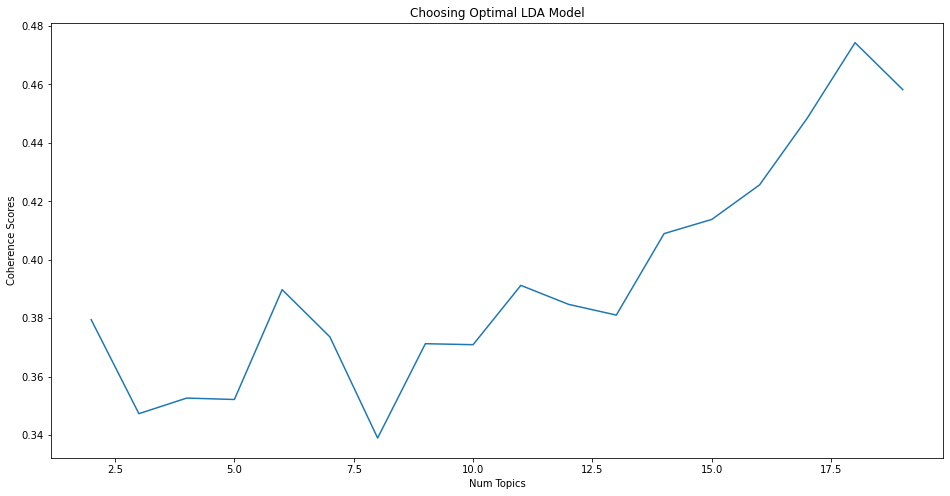

In [16]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [25]:
ntopics_des_name = 6
# We choose 6 because it has the highest coherence score reached before a major drop.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [26]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.234*"trial" + 0.077*"defamation" + 0.056*"day" + 0.036*"witness" + '
  '0.028*"actor" + 0.026*"testimony" + 0.026*"text" + 0.022*"case" + '
  '0.018*"wife" + 0.017*"ex"'),
 (1,
  '0.078*"lawyer" + 0.059*"case" + 0.045*"jury" + 0.038*"statement" + '
  '0.037*"ex" + 0.036*"wife" + 0.028*"lawsuit" + 0.027*"opening" + '
  '0.027*"libel" + 0.026*"aquaman"'),
 (2,
  '0.143*"court" + 0.071*"friend" + 0.029*"movie" + 0.025*"fan" + 0.017*"day" '
  '+ 0.017*"battle" + 0.016*"attorney" + 0.015*"claim" + 0.014*"bruise" + '
  '0.014*"case"'),
 (3,
  '0.066*"fuck" + 0.031*"marriage" + 0.027*"team" + 0.024*"thing" + '
  '0.024*"shit" + 0.022*"time" + 0.020*"twitter" + 0.018*"counselor" + '
  '0.017*"life" + 0.012*"piece"'),
 (4,
  '0.059*"abuse" + 0.040*"woman" + 0.036*"people" + 0.031*"abuser" + '
  '0.030*"man" + 0.028*"victim" + 0.023*"evidence" + 0.018*"violence" + '
  '0.017*"assistant" + 0.015*"therapist"'),
 (5,
  '0.054*"face" + 0.047*"actress" + 0.044*"video" + 0.022*"guy" + 0.020*

In [27]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [28]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [29]:
df2['Topic'] = topic_num

In [30]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
0,Inside Johnny Depp and Amber Heard's legal bat...,[battle],"[2, 1, 5, 0, 3, 4]"
1,Inside Johnny Depp and Amber Heard's legal bat...,[battle],"[2, 1, 5, 0, 3, 4]"
2,Inside Johnny Depp and Amber Heard's legal bat...,[battle],"[2, 1, 5, 0, 3, 4]"
3,BBC News - US &amp; Canada: Inside Johnny Depp...,[battle],"[2, 1, 5, 0, 3, 4]"
4,Los fans de Amber heard be like #JusticeForJoh...,[],"[0, 1, 2, 3, 4, 5]"


### Model Evaluation

In [31]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.6291901910190525
Coherence Score:  0.3686336158067802


## Visualisation

In [32]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.155988  0.196312       1        1  26.874893
0     -0.291525 -0.026107       2        1  18.321290
3      0.237373  0.111270       3        1  15.588368
2     -0.048192  0.030066       4        1  14.764788
1     -0.199356  0.051588       5        1  14.048972
5      0.145712 -0.363129       6        1  10.401689, topic_info=           Term         Freq        Total Category  logprob  loglift
2         trial  3732.000000  3732.000000  Default  30.0000  30.0000
56        court  1842.000000  1842.000000  Default  29.0000  29.0000
66       lawyer   952.000000   952.000000  Default  28.0000  28.0000
7    defamation  1545.000000  1545.000000  Default  27.0000  27.0000
40       friend   914.000000   914.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
747      sister   176.328138   328.839497   Topic6  -3.9378   1.6400
3     celebrity    71.174430    87.852845   Topic6  -4.8450   2.0527
298       watch    74.482530   114.399826   Topic6  -4.7996   1.8341
63        claim    87.626654   445.134592   Topic6  -4.6371   0.6379
361       point    70.357202   166.520892   Topic6  -4.8566   1.4017

[290 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
97        1  0.901503      abuse
97        5  0.098061      abuse
28        1  0.998491     abuser
807       3  0.987658    account
472       5  0.994536     accuse
...     ...       ...        ...
191       1  0.454151       year
191       4  0.398050       year
191       5  0.146931       year
512       3  0.987240  yesterday
279       4  0.991828    youtube

[322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 3, 2, 6])

## Word Count of Topic Keywords

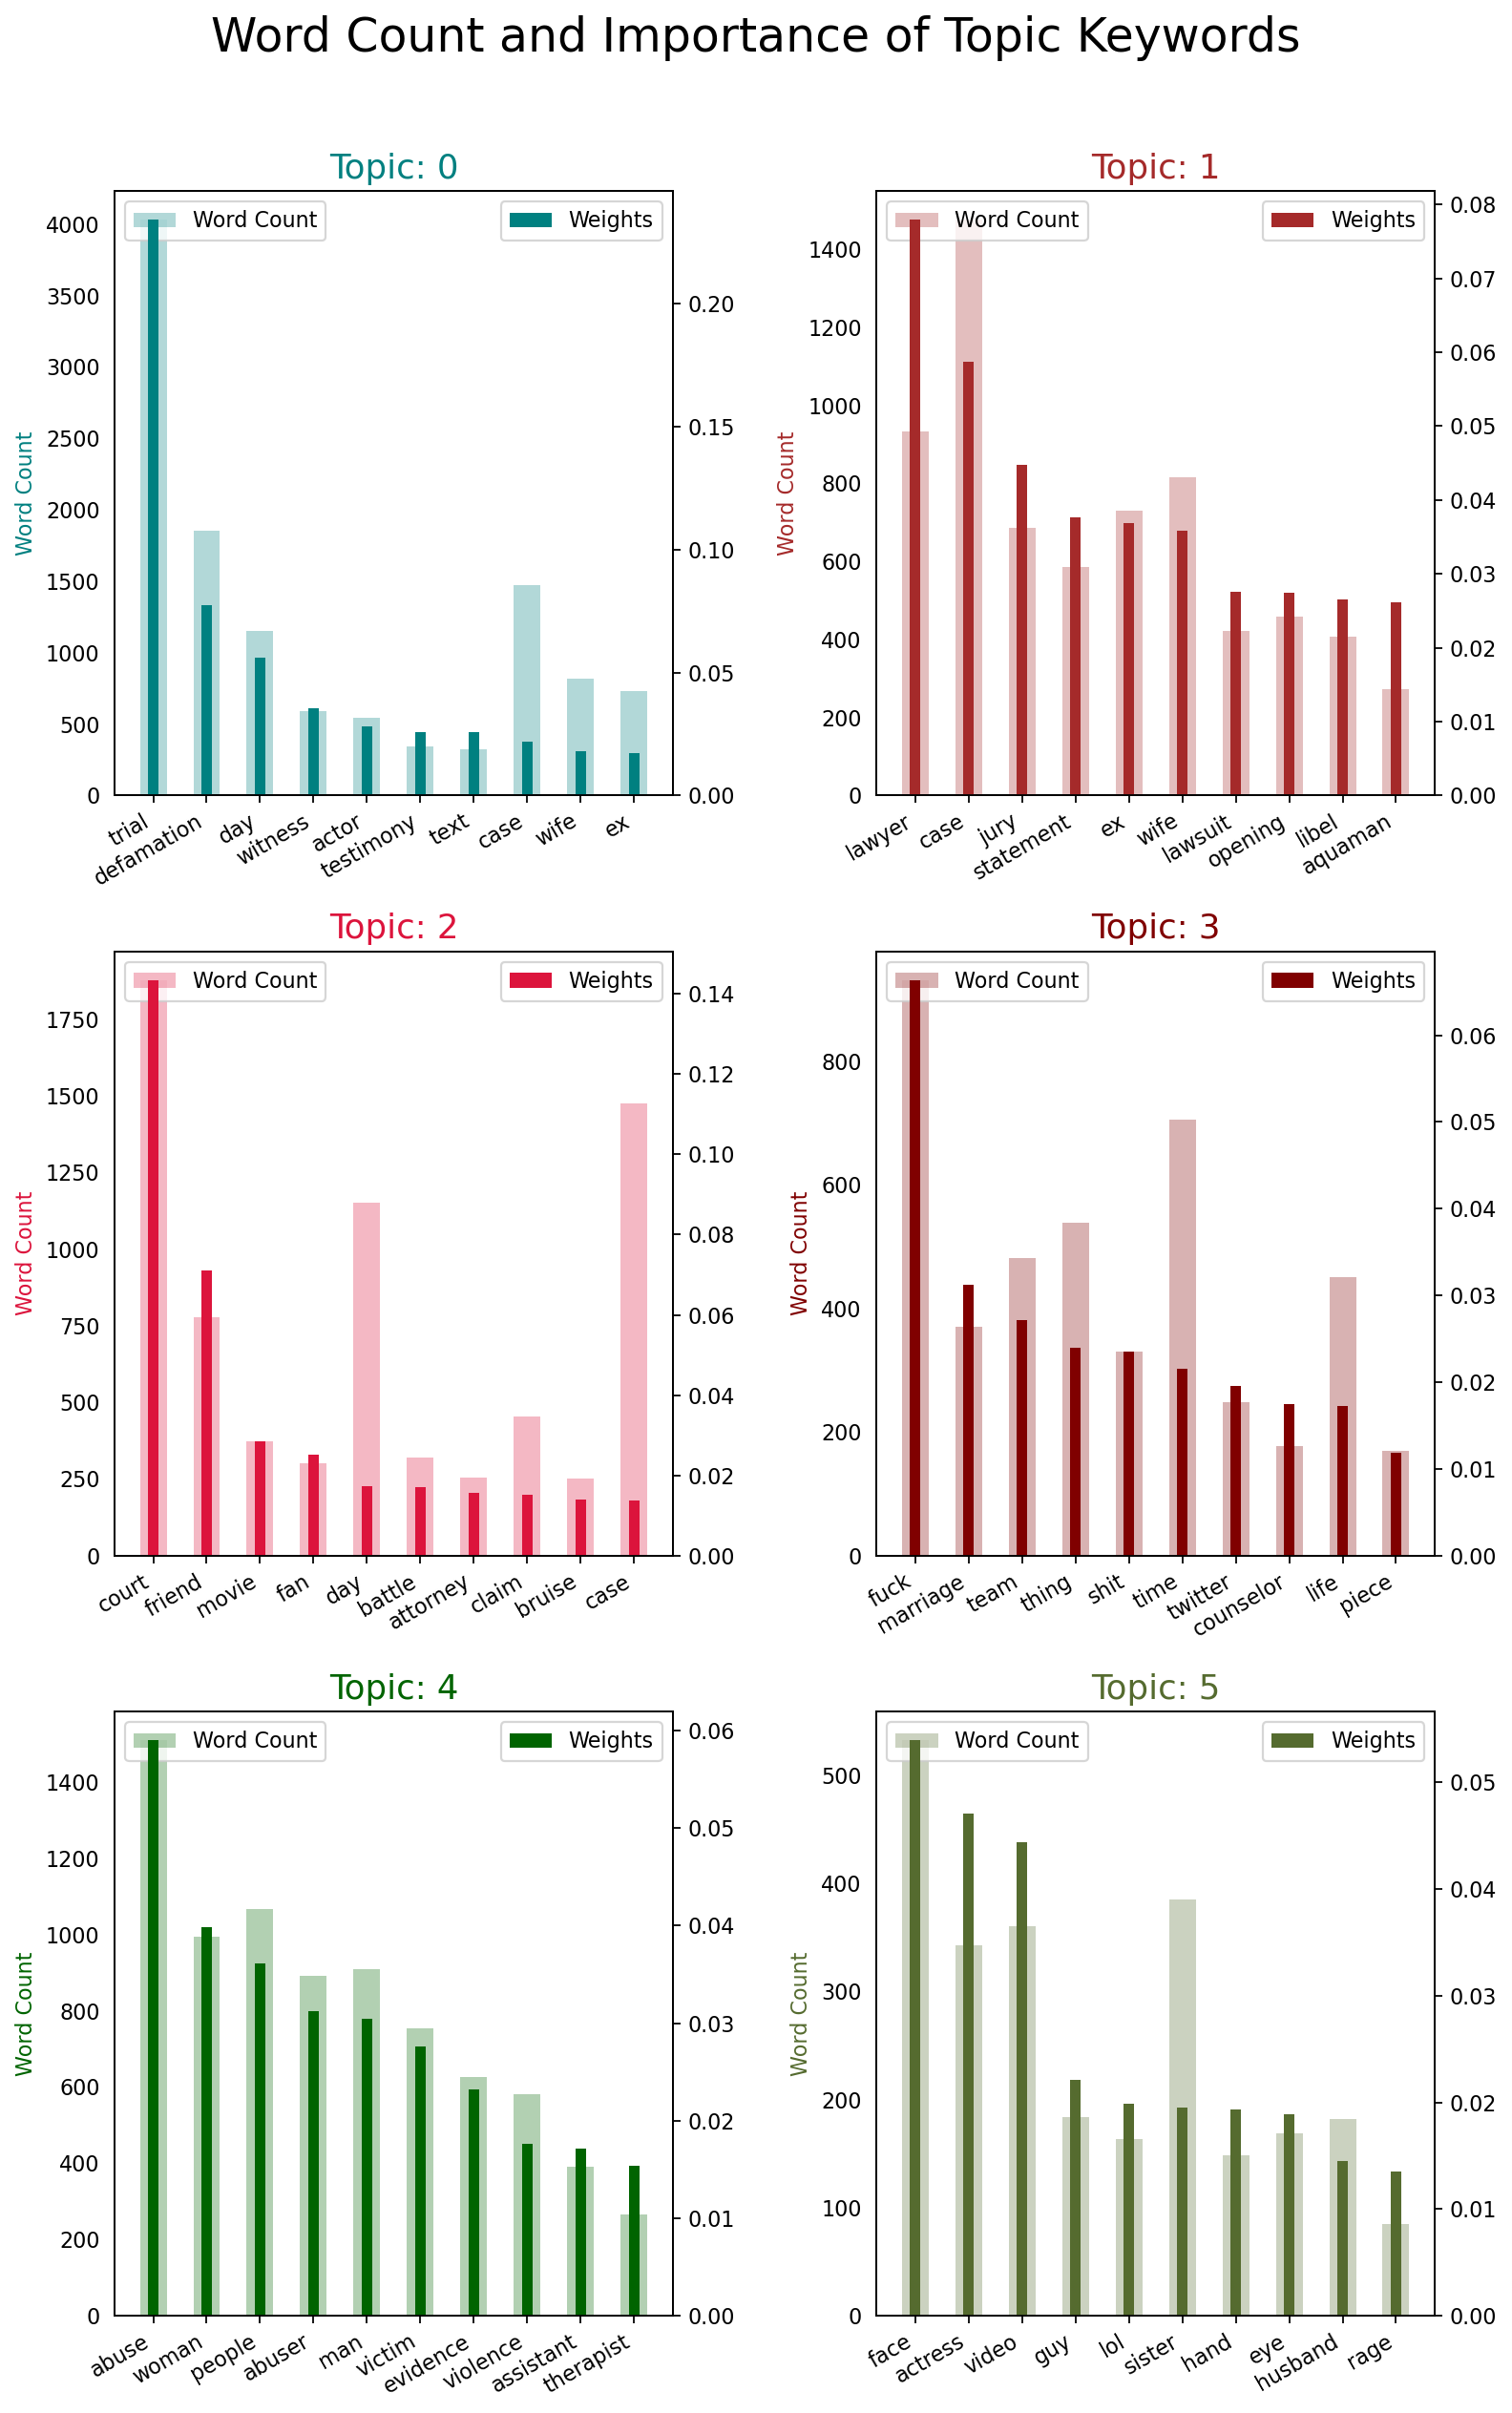

In [35]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
